### Time series calculation with OPF

This tutorial shows how a simple time series simulation with optimal power flow is performed with the timeseries and control module in pandapower. 

In [82]:
import pandapower as pp
import numpy as np
import os
import pandas as pd
import tempfile
import random
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import matplotlib.pyplot as plt
%matplotlib inline  
random.seed(10)

We created a simple network and then set the constraints for buses, lines, and external grid. We set the costs for the external grid and sgen. The cost of sgen is kept negative to maximize the generation, sgen can be controlled with OPF but not the load.

In [83]:
def simple_test_net():
    net = pp.create_empty_network()

    b0 = pp.create_bus(net, 110, min_vm_pu=0.98, max_vm_pu=1.05)
    b1 = pp.create_bus(net, 20, min_vm_pu=0.98, max_vm_pu=1.05)
    b2 = pp.create_bus(net, 20, min_vm_pu=0.98, max_vm_pu=1.05)
    b3 = pp.create_bus(net, 20, min_vm_pu=0.9, max_vm_pu=1.05)
    
    e=pp.create_ext_grid(net, b0, min_p_mw=-200, max_p_mw=200)
    costeg = pp.create_poly_cost(net, e, 'ext_grid', cp1_eur_per_mw=10)
    
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0", max_loading_percent=80)
    pp.create_line(net, b1, b2, 10, "149-AL1/24-ST1A 110.0", max_loading_percent=80)
    pp.create_line(net, b1, b3, 10, "149-AL1/24-ST1A 110.0", max_loading_percent=80)

    pp.create_load(net, b3, p_mw=10., q_mvar=-5., name='load1', controllable=False)
    g1=pp.create_sgen(net, b2, p_mw=0., q_mvar=-2, min_p_mw=0, max_p_mw=30, min_q_mvar=-3, max_q_mvar=3, name='sgen1', controllable=True)
    pp.create_poly_cost(net, g1, 'sgen1', cp1_eur_per_mw=-1)
    
    return net


We created the datasource (which contains the time series P values) and defined the range of the load power values so that the line that connects it will not be overloaded because the load will not be controlled with the OPF.

In [84]:
def create_data_source(n_timesteps=24):
    profiles = pd.DataFrame()
    profiles['load1_p'] = np.random.random(n_timesteps) * 10.
    profiles['sgen1_p'] = np.random.random(n_timesteps) * 20.

    ds = DFData(profiles)

    return profiles, ds

We created the controllers to update the P values of the load and the sgen


In [85]:
def create_controllers(net, ds):
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load1_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen1_p"])

Instead of saving the whole net (which takes a lot of time), we extract only predefined outputs. The variables of create_output_writer are saved to the hard drive after the time series loop.


In [86]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    ow.log_variable('res_sgen', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

Lets run the code for the timeseries simulation with OPF. Note that parameter 'run' is set to the function that runs OPF (run=pp.runopp).

In [87]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# create the network
net = simple_test_net()

# create (random) data source
n_timesteps = 24
profiles, ds = create_data_source(n_timesteps)

# create controllers (to control P values of the load and the sgen)
create_controllers(net, ds)

# time steps to be calculated. Could also be a list with non-consecutive time steps
time_steps = range(0, n_timesteps)

# the output writer with the desired results to be stored to files.
ow = create_output_writer(net, time_steps, output_dir=output_dir)

# the main time series function with optimal power flow
run_timeseries(net, time_steps, run=pp.runopp)

Results can be found in your local temp folder: C:\Users\mmilovic\AppData\Local\Temp\time_series_example


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:36<00:00,  1.52s/it]


We can see that all of the bus voltages are in the defined constraint range according to the optimal power flow.

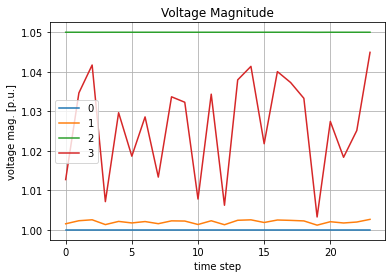

In [88]:
# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

The loading_percent of the lines are also below 80% as defined the constraints for optimal power flow.

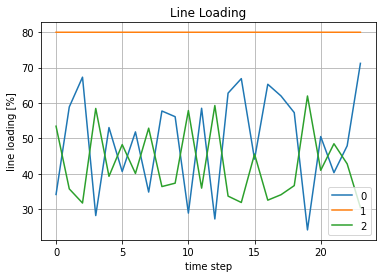

In [89]:
# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot()
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

Here we compared the sgen power generation before and after OPF.

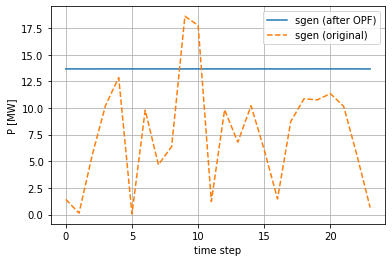

In [90]:
# sgen results
sgen_file = os.path.join(output_dir, "res_sgen", "p_mw.xlsx")
sgen = pd.read_excel(sgen_file, index_col=0)
ax=sgen[0].plot(label="sgen (after OPF)")
ds.df.sgen1_p.plot(ax=ax, label="sgen (original)", linestyle='--')
ax.legend()
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()